In [1]:
import sqlite3
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from nltk.tokenize import TweetTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [2]:
df = pd.read_csv('../../data/df_processed.csv')
df = df[(df.body_processed != 'deleted') & (df.body_processed != 'removed')]
df.head()

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,score,upvote_ratio,body_processed,title_processed,author_processed,body_and_title,body_and_author,title_and_author,body_title_and_author
1,1,kobbka,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.reddit.com/r/finance/comments/kobb...,1609507913,https://www.fintechinshorts.com/mogo-establish...,kobbka,NaN,1,1.0,no_text,mogo establishes atm equity program mogo finan...,fintechinshorts,no_text mogo establishes atm equity program mo...,no_text fintechinshorts,mogo establishes atm equity program mogo finan...,no_text mogo establishes atm equity program mo...
3,3,koe39g,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,https://www.reddit.com/r/finance/comments/koe3...,1609518689,https://www.fintechinshorts.com/standard-capit...,koe39g,NaN,1,1.0,no_text,standard capital partners solidblock standard ...,fintechinshorts,no_text standard capital partners solidblock s...,no_text fintechinshorts,standard capital partners solidblock standard ...,no_text standard capital partners solidblock s...
4,4,koefpv,finance,5 things every trader needs to know,Aversionsfall,https://www.reddit.com/r/finance/comments/koef...,1609519854,https://yvestalksbitcoin.com/2021/01/01/5-thin...,koefpv,NaN,0,0.4,no_text,things every trader needs know,aversionsfall,no_text things every trader needs know,no_text aversionsfall,things every trader needs know aversionsfall,no_text things every trader needs know aversio...
5,5,kogmfy,finance,Ten Remarkable Financial Events of 2020 - Acti...,apollo11junkie,https://www.reddit.com/r/finance/comments/kogm...,1609527162,https://www.activistpost.com/2021/01/ten-remar...,kogmfy,NaN,7,1.0,no_text,ten remarkable financial events activist post,apollo junkie,no_text ten remarkable financial events activi...,no_text apollo junkie,ten remarkable financial events activist post ...,no_text ten remarkable financial events activi...
6,6,kognqr,finance,3 reasons why Bitcoin is bull-running,snakeabait,https://www.reddit.com/r/finance/comments/kogn...,1609527288,https://yvestalksbitcoin.com/2020/12/29/3-reas...,kognqr,NaN,1,1.0,no_text,reasons bitcoin bull running,snakeabait,no_text reasons bitcoin bull running,no_text snakeabait,reasons bitcoin bull running snakeabait,no_text reasons bitcoin bull running snakeabait


In [3]:
df.columns

Index(['Unnamed: 0', 'id', 'subreddit', 'title', 'author', 'url', 'created',
       'ext_link', 'id.1', 'body', 'score', 'upvote_ratio', 'body_processed',
       'title_processed', 'author_processed', 'body_and_title',
       'body_and_author', 'title_and_author', 'body_title_and_author'],
      dtype='object')

In [4]:
df = df[['subreddit','body_title_and_author','score','created']]

In [5]:
df.shape

(226890, 4)

## Selecting subreddit with complete datasets

In [6]:
df = df[(df.subreddit == 'Superstonks') |
        (df.subreddit == 'finance') |
        (df.subreddit == 'options') |
        (df.subreddit == 'pennystocks') |
        (df.subreddit == 'GME')]

## Defining the popular posts for binary classification

In [7]:
df_superstocks = df[df.subreddit == 'Superstonks']
df_finance     = df[df.subreddit == 'finance']
df_options     = df[df.subreddit == 'options']
df_pennystocks = df[df.subreddit == 'pennystocks']
df_gme         = df[df.subreddit == 'GME']

In [8]:
df_superstocks['popular'] = 0
df_finance['popular'] = 0
df_options['popular'] = 0
df_pennystocks['popular'] = 0
df_gme['popular'] = 0

<ipython-input-8-c9e97835cf12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_superstocks['popular'] = 0
<ipython-input-8-c9e97835cf12>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finance['popular'] = 0
<ipython-input-8-c9e97835cf12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [9]:
df_superstocks.loc[df_superstocks['score'] > np.percentile(df_superstocks.score.values, 95), 'popular'] = 1
df_finance.loc[df_finance['score'] > np.percentile(df_finance.score.values, 95), 'popular'] = 1
df_options.loc[df_options['score'] > np.percentile(df_options.score.values, 95), 'popular'] = 1
df_pennystocks.loc[df_pennystocks['score'] > np.percentile(df_pennystocks.score.values, 95), 'popular'] = 1
df_gme.loc[df_gme['score'] > np.percentile(df_gme.score.values, 95), 'popular'] = 1

/Users/dutomo/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
del df
df = pd.concat([df_superstocks, df_finance, df_options, df_pennystocks, df_gme], ignore_index=True)
df.head(2)

,subreddit,body_title_and_author,score,created,popular
0,Superstonks,r superstonk sub looking r superstonk seppukkake,81,1617613228,1
1,Superstonks,no_text https www reddit com r superstonk fair...,15,1617619355,0


In [11]:
df['join_tokens'] = df['subreddit'].str.lower() + ' ' + df['body_title_and_author']

In [12]:
df.popular.unique()

array([1, 0])

In [13]:
df.head()

,subreddit,body_title_and_author,score,created,popular,join_tokens
0,Superstonks,r superstonk sub looking r superstonk seppukkake,81,1617613228,1,superstonks r superstonk sub looking r superst...
1,Superstonks,no_text https www reddit com r superstonk fair...,15,1617619355,0,superstonks no_text https www reddit com r sup...
2,Superstonks,no_text superstonk r superstonk mtgac,7,1617629799,0,superstonks no_text superstonk r superstonk mtgac
3,Superstonks,getting messages like weeks posting things cer...,11,1617639978,0,superstonks getting messages like weeks postin...
4,Superstonks,no_text r superstonk meant go stonkulus,132,1617653940,1,superstonks no_text r superstonk meant go ston...


## Dropping unnecessary columns

In [14]:
df.drop(['subreddit','score','body_title_and_author'], axis=1, inplace=True)
df.head()

,created,popular,join_tokens
0,1617613228,1,superstonks r superstonk sub looking r superst...
1,1617619355,0,superstonks no_text https www reddit com r sup...
2,1617629799,0,superstonks no_text superstonk r superstonk mtgac
3,1617639978,0,superstonks getting messages like weeks postin...
4,1617653940,1,superstonks no_text r superstonk meant go ston...


## Splitting into train and test sets by time

In [15]:
df['posting_time'] = df['created'].apply(dt.datetime.fromtimestamp)

df['posting_month'] = df['posting_time'].dt.month

df.drop(['created','posting_time'], axis=1, inplace=True)

In [16]:
df_train = df[df.posting_month < 4]
df_test  = df[df.posting_month == 4]

In [17]:
df_train.popular.sum()/len(df_train)

0.044806804668131334

In [18]:
df_test.popular.sum()/len(df_test)

0.06804078014184398

In [19]:
df_train.reset_index(drop=True, inplace=True)

In [20]:
df_test.reset_index(drop=True, inplace=True)

## Applying TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95)

tfidf_train = vectorizer.fit_transform(df_train.join_tokens.values)

tfidf_test = vectorizer.transform(df_test.join_tokens.values)

In [22]:
tfidf_train.shape

(99226, 121729)

In [23]:
y_train = df_train['popular']
y_test  = df_test['popular']

## Reduce dimensionality using SVD

In [48]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10000, n_iter=5, random_state=101)

svd.fit(tfidf_train)

TruncatedSVD(n_components=10000, random_state=101)

In [50]:
svd.components_.shape

(10000, 121729)

In [55]:
svd.explained_variance_ratio_.sum()

0.7748894315446474

In [54]:
svd.singular_values_.shape

(10000,)

## Making cross-validation data by time

In [24]:
jan_index = df_train[df_train.posting_month == 1].index
feb_index = df_train[df_train.posting_month == 2].index
mar_index = df_train[df_train.posting_month == 3].index
jan_feb_index = df_train[(df_train.posting_month == 1) | (df_train.posting_month == 2)].index

## Modeling

## Logistic Regression

In [ ]:
from sklearn.metrics import precision_score, recall_score

cv1 = [jan_index, feb_index]
cv2 = [feb_index, mar_index]
cv3 = [jan_feb_index, mar_index]

cv = [cv1, cv2, cv3]

Cs = [0.1, 1, 10]
penalties = ['l1', 'l2']

prec_val = np.zeros((3,3,2)); prec_tr = np.zeros((3,3,2))
rec_val  = np.zeros((3,3,2)); rec_tr  = np.zeros((3,3,2))

for i in range(len(cv)):
    tr_index, val_index = cv[i]
    X_tr,  y_tr  = tfidf_train[tr_index,:],  y_train[tr_index]
    X_val, y_val = tfidf_train[val_index,:], y_train[val_index]
    
    for j in range(len(Cs)):
        for k in range(len(penalties)):
    
            logreg = LogisticRegression(max_iter=10000, C = Cs[j], penalty = penalties[k],
                                        solver='liblinear', class_weight='balanced')
            logreg.fit(X_tr, y_tr)
            
            y_tr_pred  = logreg.predict(X_tr)
            y_val_pred = logreg.predict(X_val)
            
            prec_tr[i,j,k]  = precision_score(y_tr, y_tr_pred)
            prec_val[i,j,k] = precision_score(y_val, y_val_pred)
            
            rec_tr[i,j,k]  = recall_score(y_tr, y_tr_pred)
            rec_val[i,j,k] = recall_score(y_val, y_val_pred)

In [31]:
logreg = LogisticRegression(max_iter=10000, solver='liblinear', class_weight='balanced')

#param_grid = {'C': [1,10,100]}

#gs = GridSearchCV(logreg, param_grid=param_grid, scoring='f1')

logreg.fit(tfidf_train[jan_feb_index,:], y_train[jan_feb_index])

LogisticRegression(class_weight='balanced', max_iter=10000, solver='liblinear')

In [32]:
y_pred = logreg.predict(tfidf_train[jan_feb_index,:])
precision_recall_fscore_support(y_train[jan_feb_index], y_pred)

(array([0.99986544, 0.33027027]),
 array([0.92304348, 0.99673736]),
 array([0.9599199 , 0.49614292]),
 array([48300,  1839]))

In [35]:
y_pred = logreg.predict(tfidf_train[mar_index,:])
precision_recall_fscore_support(y_train[mar_index], y_pred)

(array([0.95823708, 0.15467261]),
 array([0.91028399, 0.29267357]),
 array([0.93364521, 0.20238727]),
 array([46480,  2607]))

In [34]:
y_pred = logreg.predict(tfidf_test)
precision_recall_fscore_support(y_test, y_pred)

(array([0.9430409 , 0.14833993]),
 array([0.88917955, 0.26438654]),
 array([0.91531855, 0.19004878]),
 array([25230,  1842]))

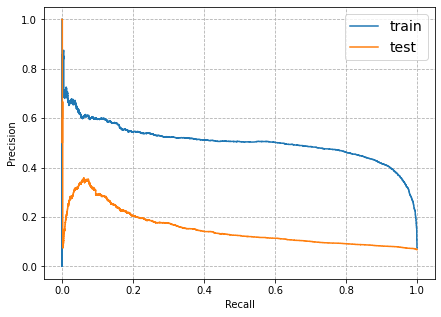

In [29]:
from sklearn.metrics import plot_precision_recall_curve

fig, ax = plt.subplots(1,1, figsize=(7,5))
plot_precision_recall_curve(logreg, tfidf_train, y_train, ax=ax, label='train')
plot_precision_recall_curve(logreg, tfidf_test, y_test, ax=ax, label='test')
plt.grid(ls='--')
plt.legend(loc='upper right', fontsize=14)
plt.show()

## XGBoost

In [36]:
from xgboost import XGBClassifier

xgb = XGBClassifier(verbosity=0)

xgb.fit(tfidf_train, y_train)

/Users/dutomo/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [37]:
y_pred = logreg.predict(tfidf_train)
precision_recall_fscore_support(y_train, y_pred)

(array([0.97915329, 0.24763903]),
 array([0.91678624, 0.58389564]),
 array([0.94694398, 0.34777949]),
 array([94780,  4446]))

In [38]:
y_pred = logreg.predict(tfidf_test)
precision_recall_fscore_support(y_test, y_pred)

(array([0.9430409 , 0.14833993]),
 array([0.88917955, 0.26438654]),
 array([0.91531855, 0.19004878]),
 array([25230,  1842]))

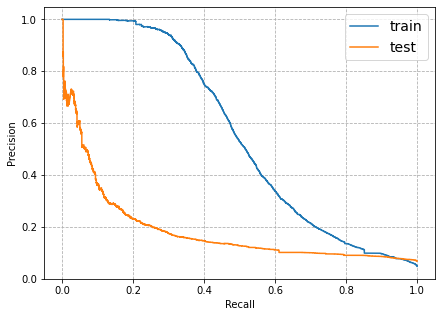

In [39]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
plot_precision_recall_curve(xgb, tfidf_train, y_train, ax=ax, label='train')
plot_precision_recall_curve(xgb, tfidf_test, y_test, ax=ax, label='test')
plt.grid(ls='--')
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [40]:
xgb = XGBClassifier(verbosity=0)

xgb.fit(tfidf_train[jan_feb_index,:], y_train[jan_feb_index])

/Users/dutomo/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [41]:
y_pred = logreg.predict(tfidf_train[jan_feb_index,:])
precision_recall_fscore_support(y_train[jan_feb_index], y_pred)

(array([0.99986544, 0.33027027]),
 array([0.92304348, 0.99673736]),
 array([0.9599199 , 0.49614292]),
 array([48300,  1839]))

In [42]:
y_pred = logreg.predict(tfidf_train[mar_index,:])
precision_recall_fscore_support(y_train[mar_index], y_pred)

(array([0.95823708, 0.15467261]),
 array([0.91028399, 0.29267357]),
 array([0.93364521, 0.20238727]),
 array([46480,  2607]))

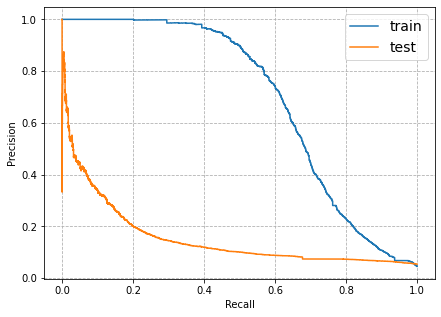

In [44]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
plot_precision_recall_curve(xgb, tfidf_train[jan_feb_index,:], y_train[jan_feb_index], ax=ax, label='train')
plot_precision_recall_curve(xgb, tfidf_train[mar_index,:], y_train[mar_index], ax=ax, label='test')
plt.grid(ls='--')
plt.legend(loc='upper right', fontsize=14)
plt.show()